# RAG with Recursive Abstractive Processing for Tree-Organized Retrival (RAPTOR)

## Load Env variables

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv('app/src/shared/.env')
GOOGLE_API_KEY = os.getenv('GOOGLE_API_KEY')

In [ ]:
import sklearn
print(sklearn.show_versions())

## Define the LLM model and embedding parameters

In [ ]:
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embd = GoogleGenerativeAIEmbeddings(model="models/embedding-001", task_type="retrieval_document", google_api_key=GOOGLE_API_KEY)
model = GoogleGenerativeAI(model="gemini-1.5-pro", temperature=0, google_api_key=GOOGLE_API_KEY)

## Document loaders - Load Sources

### Loading the pdf docs with PyPDF loader

In [ ]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_core.documents import Document
from typing import List, Dict
import os
import logging
from concurrent.futures import ThreadPoolExecutor
from typing import List


# Configure logging 
logging.basicConfig(filename='pdf_processing.log', level=logging.INFO, format='%(asctime)s %(message)s')

# Função de carregamento de PDF
def load_pdf_file(pdf_folder_path: str, filename: str) -> List[Document]:
    """Processes a single PDF file and returns the extracted elements.

    Logs information and errors during processing.
    """
    try:
        pages = []
        loader = PyPDFLoader(os.path.join(pdf_folder_path, filename))
        pages = loader.load()
        logging.info(f"Successfully processed PDF: {filename}")
        return pages
    except Exception as e:  # Catch specific PDF processing errors
        logging.error(f"Error processing PDF: {filename} - {e}")
        return []
    
    # Função para processar múltiplos PDFs
def process_multiple_pdfs(pdf_folder_path: str, max_workers: int = 8) -> Dict[str, List]:
    """Processes all PDF files within a specified folder using ThreadPoolExecutor.

    Logs information and errors during processing.
    """
    all_elements = {}
    filenames = [filename for filename in os.listdir(pdf_folder_path) if filename.endswith(".pdf")]

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        # Mapeando cada filename para a função load_pdf_file com a pasta de PDFs
        future_to_filename = {executor.submit(load_pdf_file, pdf_folder_path, filename): filename for filename in filenames}

        for future in future_to_filename:
            filename = future_to_filename[future]
            try:
                result = future.result()
                all_elements[filename] = result  # Armazenando o resultado no dicionário
            except Exception as e:
                logging.error(f"Error processing PDF: {filename} - {e}")
                all_elements[filename] = []

    return all_elements


pdf_folder_path = "app/src/database/pdf"
pdf_results = process_multiple_pdfs(pdf_folder_path)

for filename, elements in pdf_results.items():
    print(f"PDF: {filename}, Pages: {len(elements)}")

## Visualization of the texts data

In [ ]:
import tiktoken
import matplotlib.pyplot as plt

# Função para calcular o número de tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

# Inicializar lista concatenada e lista para plotagem
docs = []
all_counts = []

# Concatenar conteúdo
for filename, docs_in_file in pdf_results.items():
    docs.extend(docs_in_file)
    docs_texts = [d.page_content for d in docs_in_file]

    # Calcular o número de tokens para cada documento
    counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]
    all_counts.extend(counts)

    # Plotar o histograma de contagem de tokens para cada PDF
    plt.figure(figsize=(12, 7))
    plt.hist(counts, bins=30, color="#4C72B0", edgecolor="black", alpha=0.7)
    plt.title(f"Histogram of Token Counts for {filename}", fontsize=16)
    plt.xlabel("Token Count", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(axis="y", alpha=0.75, linestyle='--')
    
    # Melhorar a exibição das legendas
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Adicionar uma linha média
    mean_val = sum(counts) / len(counts)
    plt.axvline(mean_val, color='red', linestyle='dashed', linewidth=1)
    plt.text(mean_val * 1.1, plt.ylim()[1] * 0.9, f'Mean: {mean_val:.2f}', color = 'red')

    # Ajustar layout
    plt.tight_layout()

    # Exibir o histograma
    plt.show()

In [ ]:
print(f"Number of total pages in all documents: {len(docs)}")

## Text processing

In [ ]:
# Ordenar e reverter os documentos
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))

# Concatenar o conteúdo dos documentos
concatenated_content = "\n\n\n --- \n\n\n".join([doc.page_content for doc in d_reversed])

# Calcular o número total de tokens no conteúdo concatenado
total_tokens = num_tokens_from_string(concatenated_content, "cl100k_base")

# Exibir o número total de tokens
print(f"Num tokens in all context before cleaning the documents: {total_tokens}")

### Cleaning the text 

In [ ]:
import re

def cleaning_text(text_element: str)-> str:
    
    # Remover quebras de linha desnecessárias
    text = re.sub(r'\n+', ' ', text_element)
    
    # Remover números de página e sequências de dígitos isolados
    text = re.sub(r'\s\d+\s', ' ', text)
    
    # Remover espaços extras
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Corrigir espaços antes de pontuação
    text = re.sub(r'\s+([,.;:])', r'\1', text)
    
    return text

In [ ]:
# Apply to texts
text = [doc.page_content for doc in d_reversed]

cleaned_texts = [cleaning_text(t) for t in text]

# Concatenar o conteúdo dos documentos
concatenated_cleaned_content  = "\n\n\n --- \n\n\n".join([i for i in cleaned_texts])

# Calcular o número total de tokens no conteúdo concatenado
total_tokens = num_tokens_from_string(concatenated_cleaned_content , "cl100k_base")

# Exibir o número total de tokens
print(f"Num tokens in all context after cleaning the documents: {total_tokens}")

In [ ]:
# Doc texts split
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)

texts_split = text_splitter.split_text(concatenated_cleaned_content)
print(f"Number of text splits generated: {len(texts_split)}")

### Embedding text splits

In [ ]:
import time

# Função para calcular os embeddings com tempo de espera para evitar rate limit
def generate_embeddings(texts, embd, sleep_time=10):
    """
    Generates embeddings for a list of texts using the provided embedding model.
    
    Returns:
        list: A list of generated embeddings, corresponding to the input texts.
    """
    count = 0
    embeddings = []
    for txt in texts:
        try:
            embedding = embd.embed_query(txt)
            embeddings.append(embedding)
            count+=1
            
        except Exception as e:
            print(f"Error processing {txt[:50]}: {e}")
        
        # Rate-limit processing with sleep every 10 texts
        if count %25 == 0:
            time.sleep(sleep_time) 
        
    return embeddings

# Gerar os embeddings com tempo de espera de 1 segundo entre as requisições
global_embeddings = generate_embeddings(texts_split, embd, sleep_time=1)

# Exibir o tamanho do vetor para o primeiro chunk
print(f"Size of the vector for the chunk 0 : {len(global_embeddings[0])}")

In [ ]:
print(f"Size of the vector for the chunk 2 : {len(global_embeddings[2])}")

In [ ]:
len(global_embeddings)

In [ ]:
type(global_embeddings)

## Visualizing the clustering

In [ ]:
import matplotlib.pyplot as plt
from typing import Optional
import numpy as np
import umap

def reduce_cluster_embeddings(embeddings: np.ndarray,
                              dim: int,
                              n_neighbors: Optional[int] = None,
                              metric: str = "cosine")-> np.ndarray:
    
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
        
    result =  umap.UMAP(n_neighbors=n_neighbors, n_components=dim, metric=metric).fit_transform(embeddings)
    if not isinstance(result, np.ndarray):
        raise TypeError("Unexpected UMAP output type. Expected ndarray.")
    return result

In [ ]:
dim = 2

global_embeddings_reduced = reduce_cluster_embeddings(global_embeddings, dim)

print(global_embeddings_reduced[0])

plt.figure(figsize=(10, 8))
plt.scatter(global_embeddings_reduced[:, 0], global_embeddings_reduced[:, 1], alpha=0.5)
plt.title("Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

In [ ]:
global_embeddings_reduced

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 225

def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]

def gmm_clustering(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters

In [ ]:
labels, _ = gmm_clustering(global_embeddings_reduced, threshold=0.5)

plot_labels = np.array([label[0] if len(label) > 0 else -1 for label in labels])
plt.figure(figsize=(10, 8))

unique_labels = np.unique(plot_labels)
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, color in zip(unique_labels, colors):
    mask = plot_labels == label
    plt.scatter(global_embeddings_reduced[mask, 0], global_embeddings_reduced[mask, 1], color=color, label=f'Cluster {label}', alpha=0.5)

plt.title("Cluster Visualization of Global Embeddings")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.legend()
plt.show()

In [ ]:
num_unclassified = np.sum(plot_labels == -1)
print(f"Número de pontos não classificados: {num_unclassified}")

In [ ]:
import pandas as pd

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

df = pd.DataFrame({
    'Text': texts_split,
    'Embedding': list(global_embeddings_reduced),
    'Cluster': simple_labels
})

# Configurações do Pandas para melhor visualização
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Exibindo o DataFrame com um estilo mais legível
display(df.head(10))

In [ ]:
import pandas as pd

def format_cluster_texts(df: pd.DataFrame) -> pd.DataFrame:
    clustered_texts = []
    for cluster in df['Cluster'].unique():
        cluster_texts = df[df['Cluster'] == cluster]['Text'].tolist()
        clustered_texts.append({
            'Cluster': cluster,
            'Texts': " --- ".join(cluster_texts)
        })
    return pd.DataFrame(clustered_texts)

# Formatação e visualização dos textos agrupados por cluster
clustered_texts_df = format_cluster_texts(df)

# Configurações do Pandas para melhor visualização
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)

# Exibindo o DataFrame com os textos agrupados por cluster
display(clustered_texts_df)

In [ ]:
clustered_texts_df.columns

In [ ]:
import tiktoken
import matplotlib.pyplot as plt

# Função para calcular o número de tokens
def num_tokens_from_string(string: str, encoding_name: str) -> int:
    """Returns the number of tokens in a text string."""
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens

clustered_texts_df['NumTokens'] = clustered_texts_df['Texts'].apply(lambda x: num_tokens_from_string(x, 'cl100k_base'))

# Preparar os dados para o gráfico
cluster_sizes = clustered_texts_df[['Cluster', 'NumTokens']]

# Plotar o gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(cluster_sizes['Cluster'].astype(str), cluster_sizes['NumTokens'], color='red')
plt.xlabel('Cluster')
plt.ylabel('Number of Tokens')
plt.title('Number of Tokens per Cluster')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# calculate the mean cluster

## Summarizing the clusters - testing!

In [ ]:
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_google_genai import GoogleGenerativeAI
from langchain_google_genai import GoogleGenerativeAIEmbeddings

gemini_embeddings = GoogleGenerativeAIEmbeddings(model="models/embedding-001", task_type="retrieval_document")
model = GoogleGenerativeAI(model="gemini-1.5-pro", temperature=0)

template = """Você é um assistente para criar um resumo detalhado da entrada de texto fornecida.
Texto:
{text}
"""
prompt = ChatPromptTemplate.from_template(template)
chain = prompt | model | StrOutputParser()

In [ ]:
import time

summaries = {}
for cluster, text in clustered_texts.items():
    summary = chain.invoke({"text": text})
    summaries[cluster] = summary
    
    print(f"Sleeping for 5 seconds")
    time.sleep(5)

In [ ]:
summaries

In [ ]:
embedded_summaries = [gemini_embeddings.embed_query(summary) for summary in summaries.values()]

embedded_summaries_np = np.array(embedded_summaries)

labels, _ = gmm_clustering(embedded_summaries_np, threshold=0.5)

simple_labels = [label[0] if len(label) > 0 else -1 for label in labels]

In [ ]:
clustered_summaries = {}
for i, label in enumerate(simple_labels):
    if label not in clustered_summaries:
        clustered_summaries[label] = []
    clustered_summaries[label].append(list(summaries.values())[i])

In [ ]:
clustered_summaries

In [ ]:
final_summaries = {}
for cluster, texts in clustered_summaries.items():
    combined_text = ' '.join(texts)
    summary = chain.invoke({"text": combined_text})
    final_summaries[cluster] = summary

In [ ]:
final_summaries

In [ ]:
texts_from_df = df['Text'].tolist()
texts_from_clustered_texts = list(clustered_texts.values())
texts_from_final_summaries = list(final_summaries.values())

combined_texts = texts_from_df + texts_from_clustered_texts + texts_from_final_summaries

## Implementation of the RAPTOR - Recursive Abstractive Processing for Tree-Organized Retrieval

In [ ]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 222  # Fixed seed for reproducibility

### --- Code from citations  --- ###

def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    Perform global dimensionality reduction on the embeddings using UMAP.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - n_neighbors: Optional; the number of neighbors to consider for each point.
                   If not provided, it defaults to the square root of the number of embeddings.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    Perform local dimensionality reduction on the embeddings using UMAP, typically after global clustering.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for the reduced space.
    - num_neighbors: The number of neighbors to consider for each point.
    - metric: The distance metric to use for UMAP.

    Returns:
    - A numpy array of the embeddings reduced to the specified dimensionality.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)


def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    Determine the optimal number of clusters using the Bayesian Information Criterion (BIC) with a Gaussian Mixture Model.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - max_clusters: The maximum number of clusters to consider.
    - random_state: Seed for reproducibility.

    Returns:
    - An integer representing the optimal number of clusters found.
    """
    max_clusters = min(max_clusters, len(embeddings))
    n_clusters = np.arange(1, max_clusters)
    bics = []
    for n in n_clusters:
        gm = GaussianMixture(n_components=n, random_state=random_state)
        gm.fit(embeddings)
        bics.append(gm.bic(embeddings))
    return n_clusters[np.argmin(bics)]


def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    Cluster embeddings using a Gaussian Mixture Model (GMM) based on a probability threshold.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - threshold: The probability threshold for assigning an embedding to a cluster.
    - random_state: Seed for reproducibility.

    Returns:
    - A tuple containing the cluster labels and the number of clusters determined.
    """
    n_clusters = get_optimal_clusters(embeddings)
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)
    probs = gm.predict_proba(embeddings)
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters


def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    Perform clustering on the embeddings by first reducing their dimensionality globally, then clustering
    using a Gaussian Mixture Model, and finally performing local clustering within each global cluster.

    Parameters:
    - embeddings: The input embeddings as a numpy array.
    - dim: The target dimensionality for UMAP reduction.
    - threshold: The probability threshold for assigning an embedding to a cluster in GMM.

    Returns:
    - A list of numpy arrays, where each array contains the cluster IDs for each embedding.
    """
    if len(embeddings) <= dim + 1:
        # Avoid clustering when there's insufficient data
        return [np.array([0]) for _ in range(len(embeddings))]

    # Global dimensionality reduction
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # Global clustering
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # Iterate through each global cluster to perform local clustering
    for i in range(n_global_clusters):
        # Extract embeddings belonging to the current global cluster
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # Handle small clusters with direct assignment
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # Local dimensionality reduction and clustering
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # Assign local cluster IDs, adjusting for total clusters already processed
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters

In [ ]:
from google.api_core.exceptions import InvalidArgument

def chunk_list(lst, chunk_size):
    """Divide uma lista em partes menores de um tamanho específico."""
    for i in range(0, len(lst), chunk_size):
        yield lst[i:i + chunk_size]

def embed(texts: List[str], batch_size: int = 100) -> np.ndarray:
    """
    Generate embeddings for a list of text documents.

    This function assumes the existence of an `embd` object with a method `embed_documents`
    that takes a list of texts and returns their embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be embedded.
    - batch_size: int, maximum number of texts to process in a single batch.

    Returns:
    - numpy.ndarray: An array of embeddings for the given text documents.
    """
    all_embeddings = []
    for batch in chunk_list(texts, batch_size):
        try:
            batch_embeddings = embd.embed_documents(batch)
            all_embeddings.extend(batch_embeddings)
        except InvalidArgument as e:
            raise InvalidArgument(f"Error embedding content: {e}")
    return np.array(all_embeddings)




def embed_cluster_texts(texts):
    """
    Embeds a list of texts and clusters them, returning a DataFrame with texts, their embeddings, and cluster labels.

    This function combines embedding generation and clustering into a single step. It assumes the existence
    of a previously defined `perform_clustering` function that performs clustering on the embeddings.

    Parameters:
    - texts: List[str], a list of text documents to be processed.

    Returns:
    - pandas.DataFrame: A DataFrame containing the original texts, their embeddings, and the assigned cluster labels.
    """
    text_embeddings_np = embed(texts)  # Generate embeddings
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # Perform clustering on the embeddings
    df = pd.DataFrame()  # Initialize a DataFrame to store the results
    df["text"] = texts  # Store original texts
    df["embd"] = list(text_embeddings_np)  # Store embeddings as a list in the DataFrame
    df["cluster"] = cluster_labels  # Store cluster labels
    return df


def fmt_txt(df: pd.DataFrame) -> str:
    """
    Formats the text documents in a DataFrame into a single string.

    Parameters:
    - df: DataFrame containing the 'text' column with text documents to format.

    Returns:
    - A single string where all text documents are joined by a specific delimiter.
    """
    unique_txt = df["text"].tolist()
    return "--- --- \n --- --- ".join(unique_txt)


def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Embeds, clusters, and summarizes a list of texts. This function first generates embeddings for the texts,
    clusters them based on similarity, expands the cluster assignments for easier processing, and then summarizes
    the content within each cluster.

    Parameters:
    - texts: A list of text documents to be processed.
    - level: An integer parameter that could define the depth or detail of processing.

    Returns:
    - Tuple containing two DataFrames:
      1. The first DataFrame (`df_clusters`) includes the original texts, their embeddings, and cluster assignments.
      2. The second DataFrame (`df_summary`) contains summaries for each cluster, the specified level of detail,
         and the cluster identifiers.
    """

    # Embed and cluster the texts, resulting in a DataFrame with 'text', 'embd', and 'cluster' columns
    df_clusters = embed_cluster_texts(texts)

    # Prepare to expand the DataFrame for easier manipulation of clusters
    expanded_list = []

    # Expand DataFrame entries to document-cluster pairings for straightforward processing
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # Create a new DataFrame from the expanded list
    expanded_df = pd.DataFrame(expanded_list)

    # Retrieve unique cluster identifiers for processing
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # Summarization
    template = """Este é um trecho de um conjunto de documentos de normas regulamentadoras brasileiras (NBR's).

    As NBRs (Normas Regulamentadoras Brasileiras) definem padrões, regras e critérios que dizem respeito à aspectos da sociedade brasileira, incluindo práticas de engenharia e arquitetura\
    segurança e saúde no trabalho, qualidade de produtos e serviços, proteção ambiental, padronização de terminologia, desempenho de edificações, rotulagem de produtos, certificação de produtos e serviços.
    

    Faça um resumo detalhado da documentação fornecida.

    Documentação:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # Format text within each cluster for summarization
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # Create a DataFrame to store summaries with their corresponding cluster and level
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary


def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    Recursively embeds, clusters, and summarizes texts up to a specified level or until
    the number of unique clusters becomes 1, storing the results at each level.

    Parameters:
    - texts: List[str], texts to be processed.
    - level: int, current recursion level (starts at 1).
    - n_levels: int, maximum depth of recursion.

    Returns:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], a dictionary where keys are the recursion
      levels and values are tuples containing the clusters DataFrame and summaries DataFrame at that level.
    """
    results = {}  # Dictionary to store results at each level

    # Perform embedding, clustering, and summarization for the current level
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # Store the results of the current level
    results[level] = (df_clusters, df_summary)

    # Determine if further recursion is possible and meaningful
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # Use summaries as the input texts for the next level of recursion
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # Merge the results from the next level into the current results dictionary
        results.update(next_level_results)

    return results

### Build Tree structure

In [ ]:
docs_texts = [d.page_content for d in docs]
print(f"Number of pages of all documents: {len(docs_texts)}")

In [ ]:
print(f"Number of pages of all documents cleaned: {len(texts_split)}")

In [ ]:
# leaf_texts = docs_texts
results = recursive_embed_cluster_summarize(texts_split, level=1, n_levels=3)

### Collapsed Tree Retrieval
* Isso envolve o achatamento da estrutura da árvore em uma única camada e, em seguida, a aplicação de uma pesquisa de k vizinhos mais próximos (kNN) em todos os nós simultaneamente.
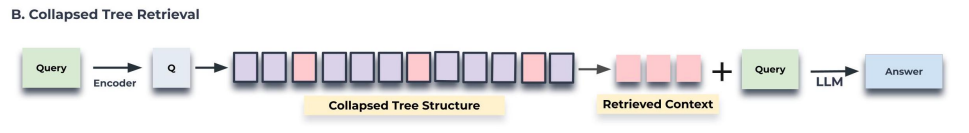

In [ ]:
type(results)

In [ ]:
results

In [ ]:
len(results)

### Add to vectorstore

In [ ]:
from langchain_community.vectorstores import Chroma

# Initialize all_texts with leaf_texts
all_texts = texts_split.copy()

# Iterate through the results to extract summaries from each level and add them to all_texts
for level in sorted(results.keys()):
    # Extract summaries from the current level's DataFrame
    summaries = results[level][1]["summaries"].tolist()
    # Extend all_texts with the summaries from the current level
    all_texts.extend(summaries)

In [ ]:
len(all_texts)

In [ ]:
print(all_texts[3])

In [ ]:
type(all_texts)

#### Add the documents to the vectorial database

In [ ]:
# Now, use all_texts to build the vectorstore with Chroma
vectorstore = Chroma.from_texts(texts=all_texts, embedding=embd)

In [ ]:
embd = GoogleGenerativeAIEmbeddings(model="models/embedding-001", task_type="retrieval_document")

# Diretório onde o vectorstore será persistido
persist_directory = "vectorstore_db"

# Inicializando o vectorstore
vectorstore = Chroma(
    collection_name="RAPTOR_vectorstore",
    embedding_function=embd,
    persist_directory=persist_directory
)

In [ ]:
import math

def split_into_batches(texts, batch_size=50):
  """Splits a list of texts into batches of a specified size."""
  num_batches = math.ceil(len(texts) / batch_size)
  batches = []
  for i in range(num_batches):
    start_index = i * batch_size
    end_index = min((i + 1) * batch_size, len(texts))
    batch = texts[start_index:end_index]
    batches.append(batch)
  return batches

# Split all_texts into batches of 100 texts each
all_texts_batches = split_into_batches(all_texts)

In [ ]:
len(all_texts_batches)

In [ ]:
print(all_texts_batches[0][0])

In [ ]:
type(all_texts_batches)

In [ ]:
for i, batch in enumerate(all_texts_batches):
    print(f"Batch {i+1} of {len(all_texts_batches)}: \nLength: {len(batch)} Type: {type(batch)}")
    print("First item type:", type(batch[0]) if batch else "Empty batch")
    if batch:
        print("First item content:", batch[0])


In [ ]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings

embd = GoogleGenerativeAIEmbeddings(model="models/embedding-001",
                                    task_type="retrieval_document", 
                                    google_api_key=GOOGLE_API_KEY,
                                    request_options= {"timeout": 1000})
embd

In [ ]:
from langchain_core.documents import Document
import uuid

# SOCORRO

# Diretório onde o vectorstore será persistido
persist_directory = "chroma_db/test_summaries/test"

# Inicializando o vectorstore
vectorstore = Chroma(
    collection_name="test",
    embedding_function=embd,
    # persist_directory=persist_directory
)

teste_do_desespero = ['oioi_teste_', 'ola']
id_key = 'docs_id_key'

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in teste_do_desespero]
page_content_test = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(teste_do_desespero)
]


In [ ]:
try:
  vectorstore.add_documents(page_content_test)
except Exception as e:  
  print(f"Error embedding documents: {e}")


In [ ]:
import sqlite3
import pandas as pd

# Conexão ao banco de dados SQLite
conn = sqlite3.connect('chroma_db/test_summaries/chroma.sqlite3')

tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(tables, "\n")

conn.close()

In [ ]:
for i, batch in enumerate(all_texts_batches):
    print(f"Batch {i+1} of {len(all_texts_batches)}: \nLength: {len(batch)} Type: {type(batch)}")
    print("First item type:", type(batch[0]) if batch else "Empty batch")
    if batch:
        # Garantir que todos os itens sejam strings
        texts = [str(text) for text in batch]
        
        # Verificar se há algum texto que não seja string ou está vazio
        for text in texts:
            if not isinstance(text, str) or not text.strip():
                print(f"Invalid text detected in batch {i+1}: {text}")
        
        # Adicionar os textos ao vectorstore
        try:
            print(texts)
            vectorstore.add_texts(texts=texts)
        except ValueError as e:
            print(f"Error adding texts in batch {i+1}: {e}")

In [ ]:
for i, batch in enumerate(all_texts_batches):
    print(f"Batch {i+1} of {len(all_texts_batches)}: \n {len(batch)} type: {type(batch)}")
    
    vectorstore.add_texts(texts=batch)

In [ ]:
import uuid

# Add texts
id_key = 'docs_id'
doc_ids = [str(uuid.uuid4()) for _ in all_texts]
page_content_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(all_texts)
]

# page_content_texts
vectorstore.add_documents(page_content_texts)

In [ ]:
#define retriver
retriever = vectorstore.as_retriever()

## RAG Pipeline

In [ ]:
from langchain_core.runnables import RunnablePassthrough
from langchain_google_genai import GoogleGenerativeAI


model = GoogleGenerativeAI(model="gemini-pro", temperature=0, top_p=0.85)

template = """
Answer the question based only on the following context:
{context}

Answer the following question:
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

rag_chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [ ]:
# Question
rag_chain.invoke("Who is the owner of the restaurant")